In [1]:
import sys
sys.path.append('../')
import scipy.io
from utils.mat_to_tfrecord_analysis import formatSessionData
from pathlib import Path
import numpy as np
import os

session = 't18.2024.12.03'
blocks = [2,3,4,5,6]
trialsToRemove = []
dataDir = str(Path('../Data', 't18', session, 'brainToText'))
data = formatSessionData(
                      blocks,
                      trialsToRemove,
                      dataDir,
                      start_offset=-150,
                      end_offset=250,
                      channels_to_exclude=[],
                      channels_to_zero=[],
                      includeThreshCrossings=True,
                      includeSpikePower=True,
                      spikePowerMax=10000,
                      globalStd=False,
                      zscoreData=True,
                      bin_compression_factor=32)

inputFeatures = data['inputFeatures']
cues = data['transcriptions']
cues = np.array([cue.strip() for cue in cues])
all_cues, counts = np.unique(cues,return_counts=True)
print('Movmement Counts: ', counts)
print(inputFeatures[0].shape)
arrays = {'All Channels' : np.arange(0,384)}

RedisMat file for block 2: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_163758_(2).mat
RedisMat file for block 3: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_165120_(3).mat
RedisMat file for block 4: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_170328_(4).mat
RedisMat file for block 5: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_172055_(5).mat
RedisMat file for block 6: ../Data/t18/t18.2024.12.03/brainToText/RedisMat/20241203_173328_(6).mat
Movmement Counts:  [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10]
(20, 768)


In [2]:
mapping=  {'LEFT PINKY - Extend Upwards':'Up',
           'LEFT PINKY - Straight Downwards':'Down',
           'LEFT PINKY - In to Palm':'In',
           'LEFT RING - Extend Upwards':'Up',
           'LEFT RING - Straight Downwards':'Down',
           'LEFT RING - In to Palm':'In',
           'LEFT MIDDLE - Extend Upwards':'Up',
           'LEFT MIDDLE - Straight Downwards':'Down',
           'LEFT MIDDLE - In to Palm':'In',
           'LEFT INDEX - Extend Upwards':'Up',
           'LEFT INDEX - Straight Downwards':'Down',
           'LEFT INDEX - In to Palm':'In',
           'LEFT THUMB - Extend Upwards':'Up',
           'LEFT THUMB - Straight Downwards':'Down',
           'LEFT THUMB - In to Palm':'In',
           'RIGHT PINKY - Extend Upwards':'Up',
           'RIGHT PINKY - Straight Downwards':'Down',
           'RIGHT PINKY - In to Palm':'In',
           'RIGHT RING - Extend Upwards':'Up',
           'RIGHT RING - Straight Downwards':'Down',
           'RIGHT RING - In to Palm':'In',
           'RIGHT MIDDLE - Extend Upwards':'Up',
           'RIGHT MIDDLE - Straight Downwards':'Down',
           'RIGHT MIDDLE - In to Palm':'In',
           'RIGHT INDEX - Extend Upwards':'Up',
           'RIGHT INDEX - Straight Downwards':'Down',
           'RIGHT INDEX - In to Palm':'In',
           'RIGHT THUMB - Extend Upwards':'Up',
           'RIGHT THUMB - Straight Downwards':'Down',
           'RIGHT THUMB - In to Palm':'In',
           'DO NOTHING': 'None'}

0.9516129032258065
[0.93548387 0.96774194]


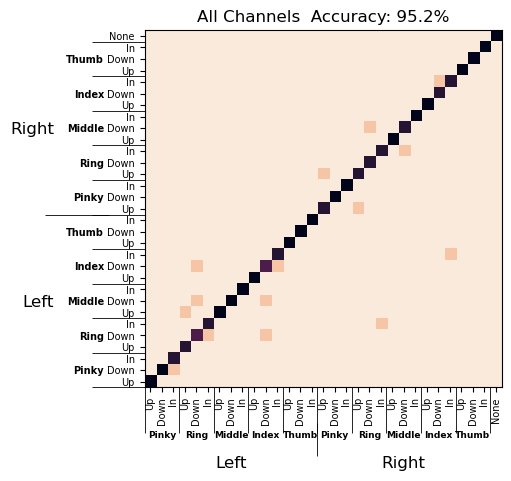

In [3]:
from utils.analysisT18 import gnb_loo, bootCI
import seaborn as sns
def plotConfusionMatrix(unroll_y, y_pred, tickLabels, orderIdx, title, figName):

    codeList = np.unique(unroll_y)
    nCodes = len(codeList)
    cMat = np.zeros([nCodes, nCodes])

    for x in range(nCodes):
        for y in range(nCodes):
            thisSum = np.sum(np.logical_and(unroll_y==codeList[orderIdx[x]], y_pred==codeList[orderIdx[y]]))
            cMat[x,y] = thisSum

    for x in range(nCodes):
        cMat[x,:] = cMat[x,:] / np.sum(cMat[x,:])    
        
    import matplotlib.pyplot as plt
    from utils.analysisT18 import plotPreamble
    plotPreamble()

    reorderLabels = tickLabels
    
    fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
    
    ax.imshow(cMat.T,clim=[0,1],cmap=sns.color_palette("rocket_r", as_cmap=True))
    ax.set_xticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels, rotation=90, fontsize=7)
    ax.set_yticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels, fontsize=7)
    sec = ax.secondary_xaxis(location=-0.08)
    sec.set_xticks([1, 4, 7,10,13,16,19,22,25,28], labels=['\nPinky', '\nRing', '\nMiddle', '\nIndex', '\nThumb','\nPinky', '\nRing', '\nMiddle', '\nIndex', '\nThumb'], fontsize=6.5)
    sec.tick_params('x', length=0)
    for lab in sec.get_xticklabels():
        lab.set_fontweight('bold')
    sec.spines['bottom'].set_linewidth(0)
    
    sec2 = ax.secondary_xaxis(location=0)
    sec2.set_xticks([-0.5, 2.5, 5.5, 8.5, 11.5, 14.5,17.5,20.5,23.5,26.5, 29.5], labels=[])
    sec2.tick_params('x', length=33, width=0.6)
    sec2.spines['bottom'].set_linewidth(0)

    sec3 = ax.secondary_xaxis(location=-0.13)
    sec3.set_xticks([7,22], labels=['\nLeft', '\nRight'], fontsize=12)
    sec3.tick_params('x', length=0)
    sec3.spines['bottom'].set_linewidth(0)

    sec4 = ax.secondary_xaxis(location=-0.1)
    sec4.set_xticks([14.5], labels=[])
    sec4.tick_params('x', length=24, width=0.6)
    sec4.spines['bottom'].set_linewidth(0)

    sec5 = ax.secondary_yaxis(location=-0.1)
    sec5.set_yticks([1, 4, 7,10,13,16,19,22,25,28], labels=['Pinky', 'Ring', 'Middle', 'Index', 'Thumb','Pinky', 'Ring', 'Middle', 'Index', 'Thumb'], fontsize=7)
    sec5.tick_params('y', length=0)
    for lab in sec5.get_yticklabels():
        lab.set_fontweight('bold')
    
    sec5.spines['left'].set_linewidth(0)
    
    sec6 = ax.secondary_yaxis(location=0)
    sec6.set_yticks([-0.5, 2.5, 5.5, 8.5, 11.5, 14.5,17.5,20.5,23.5,26.5, 29.5], labels=[])
    sec6.tick_params('y', length=38, width=0.6)
    sec6.spines['left'].set_linewidth(0)

    sec7 = ax.secondary_yaxis(location=-0.24)
    sec7.set_yticks([7,22], labels=['Left', 'Right'], fontsize=12)
    sec7.tick_params('y', length=0)
    sec7.spines['left'].set_linewidth(0)

    sec8 = ax.secondary_yaxis(location=-0.1)
    sec8.set_yticks([14.5], labels=[])
    sec8.tick_params('y', length=46, width=0.6)
    sec8.spines['left'].set_linewidth(0)
    plt.gca().invert_yaxis()
    plt.title(title,fontsize=12)
    plt.savefig(figName, bbox_inches="tight")
    plt.show()


gathered_trials = []
for i, k in enumerate(mapping):
    indices = np.array(np.argwhere(cues == k)).flatten()
    all_trials_this_phone = np.zeros((indices.shape[0],  inputFeatures[0].shape[0], inputFeatures[0].shape[-1]))    
    for j, trial in enumerate(indices):
        all_trials_this_phone[j,:inputFeatures[trial].shape[0] ,:] = np.nan_to_num(inputFeatures[trial][:21, :])
    gathered_trials.append(all_trials_this_phone)
    range_to_apply_gnb = [2,11]
save_dir = session + '-FingerSweepCMsGNBT18/'
os.makedirs(save_dir, exist_ok=True)
for array, channels_to_include in arrays.items():
    y_pred, unroll_y = gnb_loo(gathered_trials, range_to_apply_gnb, channels_to_include.astype(np.int32))
    print(np.mean(y_pred==unroll_y))
    print(bootCI(y_pred, unroll_y))

    figname =  save_dir + array + 'Blocks' + '-'.join(str(b) for b in blocks) + '.eps'
    plotConfusionMatrix(unroll_y, y_pred, mapping.values(), np.arange(len(mapping)), 
                        array + '  Accuracy: '+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%', 
                        figname)